In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
start_time = time.time()

# 以下部分与考题一相同

### 为movieId建立新的索引

In [2]:
data_raw = pd.read_csv('ratings.csv')
movie2index = {} # {movieId: index}
index2movie = {} # {index: movieId}
for index, movieId in enumerate(data_raw['movieId'].unique()):
    movie2index[movieId] = index
    index2movie[index] = movieId

### 数据预处理

In [3]:
def data_preprocess(data_path:str)->pd.DataFrame:
    """
    数据预处理
    :param data_path: 数据路径
    :return: 处理后的数据
    """
    data_raw = pd.read_csv(data_path)   # 读取数据
    data_raw = data_raw.iloc[:, :3] # 去掉时间戳
    data_raw = data_raw.sample(frac=1, random_state=42) # 打乱数据
    return data_raw

In [4]:
data_raw = data_preprocess("ratings.csv")

In [5]:
data_raw

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0
...,...,...,...
6265,42,4005,4.0
54886,364,141,4.0
76820,480,6867,4.0
860,6,981,3.0


### k折交叉验证,并转化为numpy数组

In [6]:
def get_data_matrix(data:list[list], user_num:int, movie_num:int)->np.ndarray:
    """
    获取数据矩阵
    :param data: 数据
    :param user_num: 用户数量
    :param movie_num: 电影数量
    """
    
    data_matrix = np.zeros((user_num, movie_num))
    for record in data:
        user = int(record[0])   # 用户名
        movieId = int(record[1])  # 电影
        movie = movie2index[movieId] 
        rating = record[2]      # 评分
        data_matrix[user-1, movie] = rating
    return data_matrix

In [7]:
def k_folds(data:pd.DataFrame, k=10) -> tuple[np.ndarray, np.ndarray]:
    """
    k折交叉验证
    :param data: 数据
    :param k: 折数
    :return: 训练集和验证集
    """
    user_num, movie_num = data_raw['userId'].max(), data_raw['movieId'].nunique()
    data = data.values.tolist()
    each_fold_size = len(data) // k  # 每折的长度
    for i in range(k):
        # 根据循环次数划分不同的训练集和测试集
        if i == k - 1:
            valid = data[i * each_fold_size:]
            train = data[:i * each_fold_size]
        elif i == 0:
            valid = data[: (i + 1) * each_fold_size]
            train = data[(i + 1) * each_fold_size:]
        else:
            valid = data[i * each_fold_size: (i + 1) * each_fold_size]
            train = data[: i * each_fold_size] + data[(i + 1) * each_fold_size :]

        # print(f"第{i+1}折: 训练集长度为{len(train)}, 验证集长度为{len(valid)}")
        yield get_data_matrix(train,user_num,movie_num), get_data_matrix(valid,user_num,movie_num)

In [8]:
# print(" train_len   valid_len")
for train_matrix, val_matrix in k_folds(data_raw):
    print(train_matrix.shape, val_matrix.shape)


(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)


### 计算皮尔逊系数
![Pearson](PCC.png)

In [9]:
def Pearson(rating_a, rating_b):
    """
    计算皮尔逊相关系数
    :param rating_a: 用户a的评分
    :param rating_b: 用户b的评分
    :return: 皮尔逊相关系数
    """
    temp_a = rating_a - np.mean(rating_a)
    temp_b = rating_b - np.mean(rating_b)
    numerator = np.sum(temp_a * temp_b)
    denominator = np.sqrt(np.sum(temp_a ** 2)) * np.sqrt(np.sum(temp_b ** 2))
    return numerator / denominator if denominator != 0 else np.nan

### Cosine相似度
![Cosine](Cosine.png)

In [10]:
def Cosine(rating_a, rating_b):
    """
    计算余弦相似度
    :param rating_a: 用户a的评分
    :param rating_b: 用户b的评分
    :return: 余弦相似度
    """
    numerator = np.sum(rating_a * rating_b)
    denominator = np.sqrt(np.sum(rating_a ** 2)) * np.sqrt(np.sum(rating_b ** 2))
    return numerator / denominator if denominator != 0 else np.nan

In [11]:
from typing import Callable
def calculate_similarity(train_matrix:np.ndarray, sim_func:Callable=Pearson)->np.ndarray:
    """
    计算皮尔逊相关系数
    :param train_matrix: 训练集矩阵
    :return: 皮尔逊相关系数矩阵
    """
    n_users, n_movies = train_matrix.shape # 用户数和电影数
    sim_matrix = np.full((n_users, n_users), np.nan) # 初始化皮尔逊相关系数矩阵

    # 获取每个用户看过的电影
    seen_movies = {}
    for user in range(n_users):
        seen_movies[user] = np.flatnonzero(train_matrix[user])

    for user_a in range(n_users):
        for user_b in range(n_users):
            if user_a <= user_b:    # 只计算上三角
                continue
            # 计算两个用户评价过的物品交集
            intersection_movies = np.intersect1d(seen_movies[user_a], seen_movies[user_b], assume_unique=True)

            # 如果交集为空，跳过
            if len(intersection_movies) == 0:   
                continue

            rating_a = train_matrix[user_a][intersection_movies]    # 用户a的交集电影评分
            rating_b = train_matrix[user_b][intersection_movies]    # 用户b的交集电影评分
            
            # 计算相似度
            sim_matrix[user_a][user_b] = sim_matrix[user_b][user_a] = sim_func(rating_a, rating_b)

    return sim_matrix


In [12]:
for train_matrix, val_matrix in k_folds(data_raw):
    train_matrix =train_matrix
    val_matrix = val_matrix
    break

In [13]:
pcc_matrix = calculate_similarity(train_matrix,sim_func=Pearson)

In [14]:
pcc_matrix[0]

array([            nan,             nan,  8.57492926e-02,  1.62507744e-01,
        1.85030142e-01, -2.73840122e-01, -7.24656707e-02,  4.50287265e-01,
        9.04534034e-01, -3.56348323e-01, -9.62911108e-02,             nan,
        8.70388280e-01,  2.01801838e-01,  2.74861709e-01,  8.88395473e-02,
        3.19529969e-02,  2.13184313e-01,  2.87154742e-01,  3.62652929e-01,
        3.24116186e-01, -5.45544726e-01, -5.59016994e-01,  2.33628359e-01,
       -2.50000000e-01,  1.41421356e-01,  1.38539617e-01, -2.65950148e-02,
       -1.76313813e-01, -1.66666667e-01, -2.25374703e-17,  2.59619727e-01,
        3.10885002e-02,  6.45927987e-02,  0.00000000e+00,  4.38208373e-01,
       -6.32653061e-01,  1.71829629e-01, -1.47624184e-01, -3.54005216e-01,
       -1.90207227e-01,  1.94219617e-01,  1.71377655e-01,  6.29541206e-01,
        2.31241008e-01,  4.16666667e-02,  5.62401588e-01, -1.92450090e-01,
        7.07106781e-01,  2.82884282e-02,  1.94060681e-01, -5.12989176e-01,
                   nan, -

### 获取潜在相邻用户

In [15]:
def sort_neighbor(pcc_matrix:np.ndarray)->dict:
    """
    获取潜在相邻用户
    :param pcc_matrix: 皮尔逊相关系数矩阵
    :return: 相邻用户矩阵
    """
    n_users = pcc_matrix.shape[0]
    neighbor_dict = {}
    for user in range(n_users):
        sorted_arr = np.argsort(pcc_matrix[user])[::-1] # 降序排列
        sorted_arr = sorted_arr[np.isnan(pcc_matrix[user][sorted_arr]) == False]    # 去掉nan
        neighbor_dict[user] = sorted_arr
    return neighbor_dict

In [16]:
neighbors_dict = sort_neighbor(pcc_matrix)

In [17]:
neighbors_dict[0]

array([145, 397, 549, 486, 472, 105, 597, 138, 594, 510,   8, 365,  89,
        12, 534, 480, 498, 567, 296, 113, 529, 206, 236, 161, 162,  48,
       444, 475, 393, 487, 208, 429, 542, 350, 123,  43, 172,  64, 247,
       177, 175, 573,  71, 434,  98, 112, 302, 420, 400, 217, 318, 504,
       595, 343, 466, 299,  46, 111, 339, 200, 506, 214, 262, 368, 574,
       209, 497, 184,  54, 132, 301, 167, 441, 284, 134, 235, 125, 374,
       493, 476, 525, 205, 478, 430, 171, 300, 322, 450, 448, 347, 596,
         7, 349,  35, 275,  74, 245, 144, 282, 483, 413, 520, 269, 166,
       388, 213, 307, 188, 522,  68, 511, 592,  61, 417, 225, 571, 337,
       169, 119, 137, 326, 512, 315, 215, 135, 551, 539, 159,  75, 198,
        56, 211, 118,  19, 554, 463, 378, 121, 241, 313, 535, 455, 509,
       447, 433, 286, 607, 311, 191, 170, 265, 599, 503,  20,  99, 248,
       384, 267, 243, 154, 199, 589, 306, 576, 446,  18, 523, 482, 164,
       411,  88, 457,  14, 494, 367, 309, 502, 218,  92, 507,  3

In [18]:
pcc_matrix[0][neighbors_dict[0]]

array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  9.17662935e-01,
        9.04534034e-01,  9.04534034e-01,  9.04534034e-01,  9.04534034e-01,
        8.96421457e-01,  8.70388280e-01,  8.68599036e-01,  8.66025404e-01,
        8.02955069e-01,  8.01783726e-01,  7.91922945e-01,  7.59256602e-01,
        7.55928946e-01,  7.30296743e-01,  7.26815568e-01,  7.08333333e-01,
        7.07106781e-01,  7.07106781e-01,  7.00472797e-01,  6.93375245e-01,
        6.81919047e-01,  6.73900752e-01,  6.66666667e-01,  6.54653671e-01,
        6.45497224e-01,  6.32455532e-01,  6.30714997e-01,  6.29541206e-01,
        6.17213400e-01,  6.12372436e-01,  6.12372436e-01,  6.04056767e-01,
        5.98799461e-01,  5.97614305e-01,  5.94467772e-01,  5.89767825e-01,
        5.83450035e-01,  5.80947502e-01,  5.79954809e-01,  5.78351745e-01,
        5.77350269e-01,  5.77350269e-01,  5.77350269e-01,  5.77350269e-01,
        5.76741477e-01,  

### 计算训练集中每个用户的平均分

In [19]:
def avg(train_matrix:np.ndarray)->np.ndarray:
    """
    计算每个用户的平均评分
    :param train_matrix: 训练集矩阵
    :return: 每个用户的平均评分
    """
    n_users, n_movies = train_matrix.shape
    avg_array = np.full(n_users, 3.5)   # 初始化为3.5
    for user in range(n_users):
        avg_array[user] = np.mean(train_matrix[user][train_matrix[user] != 0])
    return avg_array

In [20]:
avg_array = avg(train_matrix)
avg_array[:10]

array([4.33333333, 3.92592593, 2.52941176, 3.51269036, 3.62790698,
       3.49462366, 3.25954198, 3.68421053, 3.28888889, 3.2375    ])

### 预测评分
![predict](predict.png)

In [21]:
def predict(train_matrix:np.ndarray, valid_matrix:np.ndarray, pcc_matrix:np.ndarray, neighbors_dict:dict, avg_array:np.ndarray, neighbor_num:int)->np.ndarray:
    """
    预测用户对电影的评分
    :param train_matrix: 训练集矩阵
    :param valid_matrix: 验证集矩阵
    :param pcc_matrix: 皮尔逊相关系数矩阵
    :param neighbors_dict: 相邻用户字典
    :param avg_array: 每个用户的平均评分
    :param neighbor_num: 相邻用户的个数
    :return: 预测矩阵
    """
    pred_matrix = np.zeros(valid_matrix.shape)
    # neighbor_used = [] # 记录预测每部电影时使用的相邻用户的个数
    
    for user in range(pred_matrix.shape[0]):
        to_predict_movies = np.flatnonzero(valid_matrix[user])  # 需要预测的电影
        neighbors = neighbors_dict[user]    # 潜在相邻用户
        for movie in to_predict_movies: # 遍历每个需要预测的电影
            numerator = 0
            denominator = 0
            neighbors_now = 0 # 记录当前使用的相邻用户的个数
            for neighbor in neighbors:  # 遍历每个潜在相邻用户
                if train_matrix[neighbor, movie] == 0:  # 如果相邻用户没有评价过该电影，则跳过
                    continue
                
                neighbors_now += 1
                numerator += pcc_matrix[user, neighbor] * (train_matrix[neighbor, movie] - avg_array[neighbor])
                denominator += abs(pcc_matrix[user, neighbor])

                if neighbors_now >= neighbor_num:  # 如果已使用的邻居数量已达到要求，则跳出循环
                    break
            # neighbor_used.append(neighbors_now)
            pred_matrix[user, movie] = avg_array[user] + numerator / denominator if denominator != 0 else avg_array[user]
    # print(f"使用的邻居数量：{np.mean(neighbor_used)}")  # 平均使用的相邻用户的个数
    return pred_matrix

In [22]:
predict_matrix = predict(train_matrix, val_matrix, pcc_matrix, neighbors_dict, avg_array, neighbor_num=100)

In [23]:
predict_matrix[0][predict_matrix[0] != 0]

array([3.68054047, 4.4245708 , 4.50306225, 5.01889796, 4.6885787 ,
       4.49870266, 4.15257603, 4.47949557, 4.56827194, 4.82101365,
       4.32602564, 4.71892038, 4.42683205, 4.09094199, 4.6927267 ,
       4.01194207, 3.90584459, 4.66340572, 4.39036123, 4.44288729,
       4.57083333, 4.90759666, 4.76610595, 4.7228964 , 4.85559464])

# 以上部分与考题一相同

### 获取不同邻居时的所有预测对象

In [24]:
from Observation import Observation_of_prediction
from typing import Callable, Optional
def get_all_observations(data_path:str, neighbor_nums:list[int], fold_num:int=10, sim_func:Callable=Pearson, log=True)->list[Observation_of_prediction]:
    """
    获取不同邻居下的所有预测值
    :param data_path: 数据路径
    :param neighbor_nums: 相邻用户个数(仅在使用Pearson或Cosine时使用)
    :param fold_num: 折数
    :param sim_func: 相似度计算方法
    :return: 所有预测值
    """
    print(sim_func.__name__)

    data_raw = data_preprocess(data_path)
    # k折验证
    for i, (train_matrix, val_matrix) in enumerate(k_folds(data_raw, k=fold_num)):
        observation_list = []
        if log:
            print(f"第{i+1}折")
        sim_matrix = calculate_similarity(train_matrix, sim_func=sim_func)
        neighbors_dict = sort_neighbor(sim_matrix)
        avg_array = avg(train_matrix)
        # 不同的邻居个数
        for neighbor_num in neighbor_nums:
            if log:
                print(f"邻居个数: {neighbor_num}")
            predict_matrix = predict(train_matrix, val_matrix, sim_matrix, neighbors_dict, avg_array, neighbor_num=neighbor_num)
            nonzero_indices = np.nonzero(val_matrix)
            # 将每个预测值保存到列表中
            for user, item in zip(nonzero_indices[0], nonzero_indices[1]):
                userId = user + 1
                movieId = index2movie[item]
                observation_list.append(Observation_of_prediction(userId, movieId, neighbor_num, predict_matrix[user, item], val_matrix[user, item], avg_array[user]))

        yield observation_list

# 以下仅为第一折

In [25]:
neighbor_nums = [i for i in range(1,10)] + [i for i in range(10, 25, 3)] + [i for i in range(25, 101, 5)]
for group in get_all_observations("ratings.csv", neighbor_nums, fold_num=10, sim_func=Pearson):
    observation_list_all = group
    break

Pearson
第1折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100


### MAE & RMSE

In [26]:
from itertools import groupby
from Error import Error

observation_list_all.sort(key=lambda x: x.neighbors)
for neighbor_num, group in groupby(observation_list_all, key=lambda x: x.neighbors):
    error = Error(list(group))
    print(f"邻居个数: {neighbor_num}, MAE: {error.MAE()}, RMSE: {error.RMSE()}")

邻居个数: 1, MAE: 0.9233965821664388, RMSE: 1.1983742084509017
邻居个数: 2, MAE: 0.8077342477907961, RMSE: 1.04609724710129
邻居个数: 3, MAE: 0.7656416492572713, RMSE: 0.9960792072625239
邻居个数: 4, MAE: 0.745104589033021, RMSE: 0.9715346136915326
邻居个数: 5, MAE: 0.7283641636922, RMSE: 0.9523182020714018
邻居个数: 6, MAE: 0.7213604887315751, RMSE: 0.9429040363005696
邻居个数: 7, MAE: 0.7156858685330956, RMSE: 0.9359256211697861
邻居个数: 8, MAE: 0.7093702449250455, RMSE: 0.930202518278581
邻居个数: 9, MAE: 0.7048121457924854, RMSE: 0.9256501734621507
邻居个数: 10, MAE: 0.7017085354695093, RMSE: 0.9220547966071829
邻居个数: 13, MAE: 0.6955687218977795, RMSE: 0.9151338887054178
邻居个数: 16, MAE: 0.6920256000349588, RMSE: 0.9117775122790102
邻居个数: 19, MAE: 0.6903759990216115, RMSE: 0.9097201149503229
邻居个数: 22, MAE: 0.6891485377851442, RMSE: 0.9083445143161547
邻居个数: 25, MAE: 0.6877393147132556, RMSE: 0.9068602513987154
邻居个数: 30, MAE: 0.6865545909901194, RMSE: 0.9061804429292653
邻居个数: 35, MAE: 0.6855840530736812, RMSE: 0.9051301785631

### Accuracy, Precision, Recall, F1

In [27]:
from Metric import Metric, Count, Positive_or_negative
from itertools import groupby

observation_list_all.sort(key=lambda x: x.neighbors)
for neighbor_num, group in groupby(observation_list_all, key=lambda x: x.neighbors):
    metric = Metric(list(group))
    print(metric.accuracy(), metric.precision(), metric.recall(), metric.f1())

0.5772091639393038 0.6051448102176651 0.6192930780559647 0.612137203166227
0.597540414559159 0.6215929203539823 0.646539027982327 0.6338206099981952
0.6068630367946047 0.6288171288171288 0.6596097201767305 0.6438454627133872
0.6085490429435684 0.6299212598425197 0.6627393225331369 0.6459136987530276
0.6207477933154815 0.6402162539239623 0.6758100147275405 0.6575317929428622
0.6230288604581969 0.64 0.6863033873343152 0.6623434307541974
0.622830506793613 0.6393022062596203 0.6881443298969072 0.6628247185034134
0.6266984032530001 0.6417403127124405 0.695139911634757 0.6673736302580416
0.6261033422592482 0.6407520325203252 0.6964285714285714 0.6674311926605504
0.6292770008925915 0.6426406197372853 0.7025036818851251 0.671240105540897
0.6329465436873947 0.6444667000500751 0.7107879234167894 0.6760045522192069
0.6371119706436577 0.646795827123696 0.7190721649484536 0.6810217069130852
0.6360210254884459 0.6450444517616069 0.7212812960235641 0.6810359812271859
0.6361202023207378 0.644012416271

### 排序性能

In [61]:
from itertools import groupby
from Ranking import RankingPerformance

ranking_list_all = {}  # {neighbor_num: {user: ranking list}}
observation_list_all.sort(key=lambda x: x.neighbors)
for neighbor_num, group in groupby(observation_list_all, key=lambda x: x.neighbors):
    group_list = list(group)
    ranking = RankingPerformance(group_list)
    print(ranking.HLU(h=2), ranking.NDCG(b=2))
    ranking_list_all[neighbor_num] = ranking.ranking_list_dict

0.8158362360685251 0.6256023520794026
0.8489117297022917 0.6434997805517148
0.8582453059090438 0.6553429467946508
0.8679600422654796 0.6642464935795355
0.8763226266551646 0.6711588865150031
0.8945772809515804 0.6796809220567017
0.8962792567147678 0.6802633453030118
0.8899578866321478 0.687337372187281
0.9034670479576851 0.6919676624872214
0.9130572051699744 0.6980334580480994
0.9179863131442675 0.7060287179205179
0.9339114825049523 0.7132518268949195
0.93857852585218 0.7126091103687388
0.9339014204661568 0.7139521826715598
0.9492425867766379 0.7148468143225174
0.9556686858568252 0.7159828103425598
0.9652575610653183 0.7185460478248155
0.9680020807070496 0.7185739947771174
0.9679938102142134 0.7183349088432656
0.9657668146854012 0.7174324424090984
0.965687628803592 0.7169632819412889
0.9643462105911128 0.7174939008382419
0.9623874924653135 0.7168486529302953
0.9685295712990768 0.7161544788311885
0.964453962082562 0.7155801162092762
0.9660620306005145 0.7178658201319797
0.967019175904729

In [62]:
print(ranking_list_all[1][1])   # 在邻居数量为1时，1号用户的预测列表和实际列表

user:1	neighbor:1	avg:4.333333333333333
pred movie	pred rating			act rating			act movie	act rating
1587		5.942254495159059		5.0				596		5.0
596		5.645833333333333		5.0				1029		5.0
1580		5.488888888888889		3.0				1198		5.0
2640		5.426356589147287		4.0				1278		5.0
2991		5.245098039215685		5.0				1587		5.0
1029		5.10919540229885		5.0				1927		5.0
3740		4.745098039215686		4.0				1954		5.0
3578		4.719961240310077		5.0				2048		5.0
1954		4.687664041994751		5.0				2078		5.0
2387		4.687664041994751		5.0				2115		5.0
2115		4.571969696969697		5.0				2353		5.0
2899		4.570833333333333		5.0				2387		5.0
1198		4.5650406504065035		5.0				2459		5.0
2459		4.481481481481481		5.0				2529		5.0
1927		4.355805243445692		5.0				2899		5.0
2078		4.175438596491228		5.0				2991		5.0
2353		4.175438596491228		5.0				3034		5.0
1278		4.0650406504065035		5.0				3578		5.0
2529		3.9836400817995905		5.0				1500		4.0
2048		3.9422544951590592		5.0				2492		4.0
2492		3.896660365469439		4.0				2640		4.0
3034		3.7857142857

# 完整流程

In [31]:
fold_num = 10
sim_func = Pearson
neighbor_nums = [i for i in range(1,10)] + [i for i in range(10, 25, 3)] + [i for i in range(25, 101, 5)]

In [32]:
# 创建一个字典来存储所有的评估指标
evaluations = {
    'MAE': [0] * len(neighbor_nums),
    'RMSE': [0] * len(neighbor_nums),
    'accuracy': [0] * len(neighbor_nums),
    'precision': [0] * len(neighbor_nums),
    'recall': [0] * len(neighbor_nums),
    'f1': [0] * len(neighbor_nums),
    'HLU': [0] * len(neighbor_nums),
    'NDCG': [0] * len(neighbor_nums)
}

In [33]:
from itertools import groupby
from Error import Error
from Metric import Metric
from Ranking import RankingPerformance

for observation_list in get_all_observations("ratings.csv", neighbor_nums, fold_num=10, sim_func=Pearson):
    # 每个折的所有预测值组成的列表
    observation_list.sort(key=lambda x: x.neighbors)
    for i, (neighbor_num, group) in enumerate(groupby(observation_list, key=lambda x: x.neighbors)):
        """
        错误的写法：
        error = Error(list(group))      
        metric = Metric(list(group))    
        ranking = RankingPerformance(list(group), h=2, b=2)

        `groupby`函数返回的`group`是一个迭代器。
        当你第一次调用`list(group)`时，迭代器会遍历所有的元素并返回一个列表。
        然后，当你再次调用`list(group)`时，由于迭代器已经遍历过所有的元素，所以它不会返回任何元素，结果就是一个空列表。
        你可以通过将`group`转换为列表并将其存储在一个变量中来解决这个问题，然后在后续的代码中使用这个变量。
        这样，你就可以多次使用这个列表而不会遇到迭代器已经耗尽的问题。
        """
        group_list = list(group)
        error = Error(group_list)
        metric = Metric(group_list)
        ranking = RankingPerformance(group_list)

        evaluations['MAE'][i] += error.MAE()
        evaluations['RMSE'][i] += error.RMSE()
        evaluations['accuracy'][i] += metric.accuracy()
        evaluations['precision'][i] += metric.precision()
        evaluations['recall'][i] += metric.recall()
        evaluations['f1'][i] += metric.f1()
        evaluations['HLU'][i] += ranking.HLU(h=2)
        evaluations['NDCG'][i] += ranking.NDCG(b=2)


Pearson
第1折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第2折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第3折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第4折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻

In [34]:
# 除以折数
for key in evaluations:
    evaluations[key] = [i / fold_num for i in evaluations[key]]

In [35]:
def plot(x, y, xlabel, ylabel, title):
    plt.plot(x, y, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

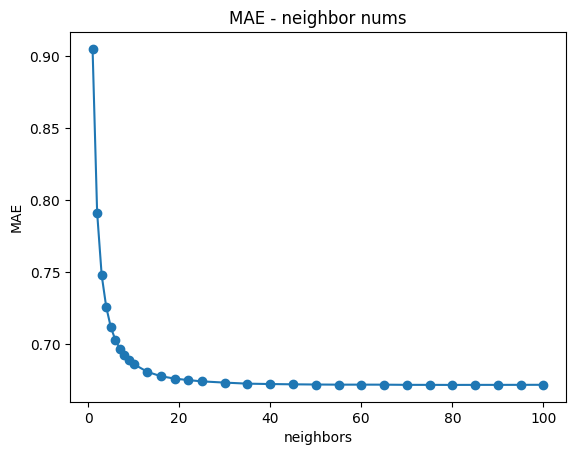

In [36]:
plot(neighbor_nums, evaluations['MAE'], 'neighbors', 'MAE', 'MAE - neighbor nums')

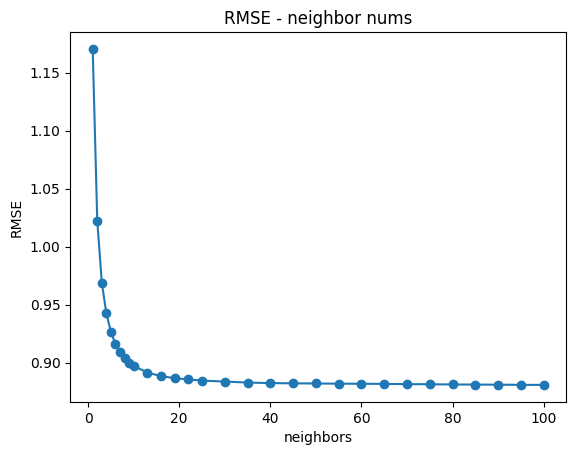

In [37]:
plot(neighbor_nums, evaluations['RMSE'], 'neighbors', 'RMSE', 'RMSE - neighbor nums')

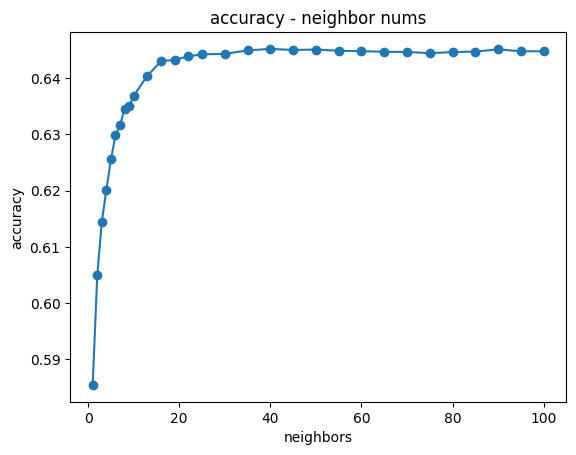

In [38]:
plot(neighbor_nums, evaluations['accuracy'], 'neighbors', 'accuracy', 'accuracy - neighbor nums')

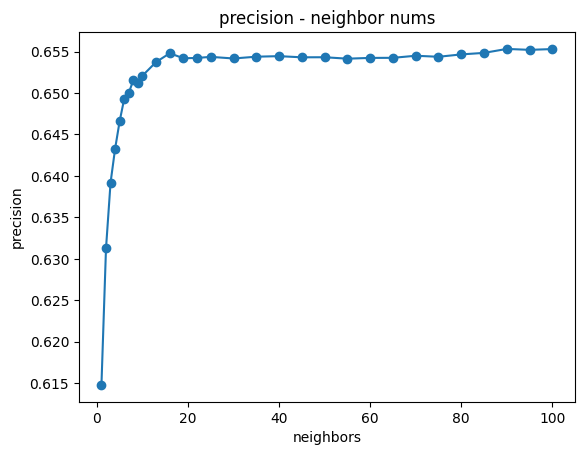

In [39]:
plot(neighbor_nums, evaluations['precision'], 'neighbors', 'precision', 'precision - neighbor nums')

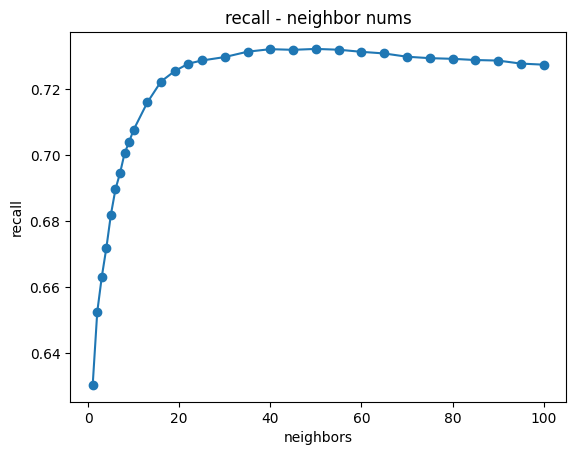

In [40]:
plot(neighbor_nums, evaluations['recall'], 'neighbors', 'recall', 'recall - neighbor nums')

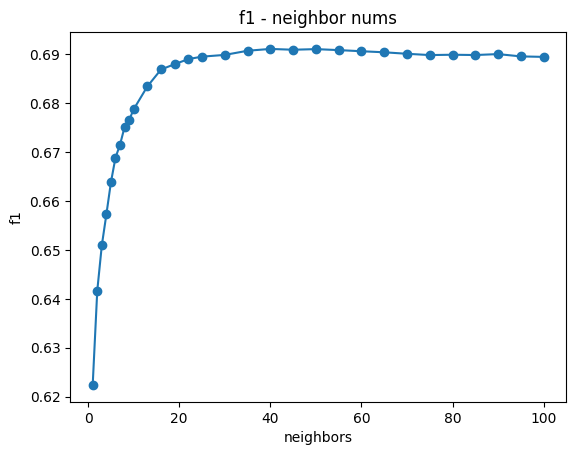

In [41]:
plot(neighbor_nums, evaluations['f1'], 'neighbors', 'f1', 'f1 - neighbor nums')

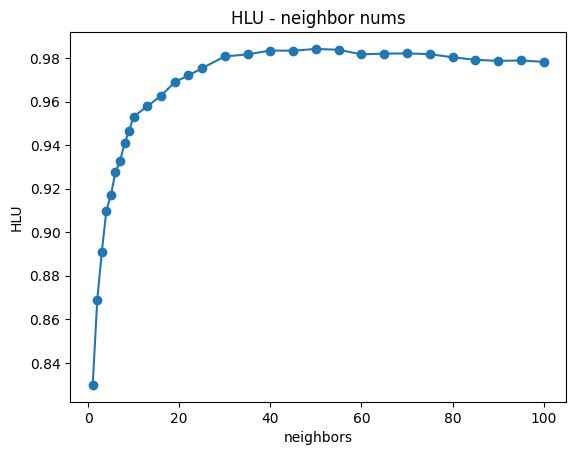

In [42]:
plot(neighbor_nums, evaluations['HLU'], 'neighbors', 'HLU', 'HLU - neighbor nums')

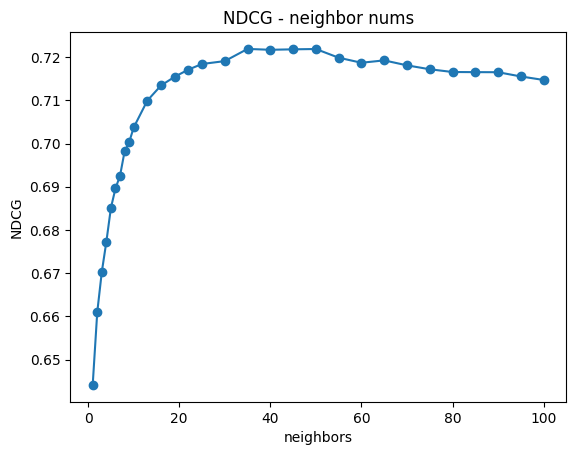

In [43]:
plot(neighbor_nums, evaluations['NDCG'], 'neighbors', 'NDCG', 'NDCG - neighbor nums')

In [44]:
print(f"运行时间：{time.time() - start_time}s")

运行时间：465.3299386501312s
